# Introduction & Fermionic Circuits

In digital quantum computing, the fundamental unit of information is typically an addressable two-level quantum system called a qubit. Within the circuit model, each qubit is assigned a wire in the circuit. After _initialization_ in a well-defined state (e.g. the ground state 0), gates applied to these wires describe an _evolution_ of the state under a sequence of unitary operations. A _measurement_ on a wire then projects the corresponding unit of information onto one of its internal states (0 or 1 for qubits).

Quantum simulation architectures based on cold atoms have been vastly explored for the simulation of condensed matter systems in the last two decades. [1] Their experimental control has advanced to a point where they now offer varying degrees of programmability making them strong candidates for a novel kind of quantum information processor.
Similar to the qubit circuits described above, experiments run on cold atomic quantum simulators are also commonly described by an _initialization_ in some easy-to-prepare state, a subsequent _evolution_ of the state under programmable unitary operations and finally a _measurement_ yielding information about the quantum state of the atoms such as location, momentum or spin. 

Due to these similarities between the qubits and cold atomic quantum systems we can abstract quantum computations and simulations run on cold atomic systems in quantum circuits where the wires represent the internal degrees of freedom of the atoms which are accessed by the measurement. 

Qiskit's cold atom module explores such circuit-based descriptions of cold atomic experiments, leveraging the existing Qiskit control stack and building upon functionality such as circuits, backends, gates, providers etc.  

Specifically, this module enables two different settings:  

1.  A "fermionic" setting where the individual units of information are the occupations of fermionic modes realized by trapped fermionic atoms as described in this tutorial. 
2. A \"spin\" setting where the individual units of information are orientations of long spins as realized by trapped Bose-Einstein-Condensates. This is introduced in the [spin circuits tutorial](./02_spin_circuits.ipynb).

## Fermionic setting

In a fermionic setting, the wires of a quantum circuit describe the occupations of individual fermionic modes. Due to the Pauli exclusion principle, a fermionic mode can either be empty, i.e. in the "vacuum state" $\left| 0 \right>$ or occupied $\left| 1 \right>$. However, no two particles can occupy the same mode. We assign one wire to each fermionic mode in the quantum circuit describing such systems.

Before applying gates to this fermionic register, we need to initialize some modes with particles, which is done with a `load` instruction. Importing the `qiskit_cold_atom.fermions` module will add this instruction to the `QuantumCircuit` class.

In [1]:
from qiskit_cold_atom.fermions import FermionSimulator

# initialize the generic fermionic simulator backend
backend = FermionSimulator()

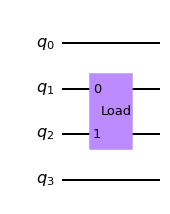

In [2]:
from qiskit import QuantumCircuit

circ1 = QuantumCircuit(4)  # Create a quantum circuit describing four fermionic modes.

circ1.load_fermions([1, 2])  # Load fermions into modes 1 and 2.

circ1.draw(output='mpl')

A measurement will yield the occupations of each wire. Let's run the circuit on the `FermionSimulator` backend and confirm this. Calling `backend.run()` will create an `AerJob` object from qiskit-aer which comes with the same functionality to handle jobs familiar from the Aer simulation backends, such as a `.result()` method to retrieve the results. 

In [3]:
circ1.measure_all()

job = backend.run(circ1)  # defaults to 1000 shots taken

print(job.result().get_counts())

{'0110': 1000}


A fermionic register can also be created directly from a list of initial occupations:

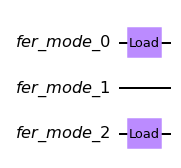

In [4]:
circ2 = backend.initialize_circuit([1, 0, 1])

circ2.draw(output='mpl')

Observe that the first quantum circuit has a register named `q` while the second circuit has a register named `fer_mode` to emphasize that the wires are fermionic in nature. This does not affect the instructions that can be added to a circuit and reminds us of the different nature of the wires. Circuits with registers labeled `fer_mode` can be conveniently obtained from the cold atom backend instances using the `initialize_circuit` method.

In [5]:
print(f"First circuit's register: {circ1.qregs}")
print(f"Second circuit's register: {circ2.qregs}")

First circuit's register: [QuantumRegister(4, 'q')]
Second circuit's register: [QuantumRegister(3, 'fer_mode')]


## Fermionic Gates

Quantum gates define the unitary operations that are carried out on the system. The gate unitary $U$ can be uniquely identified by the hermitian Hamiltonian $H$ that generates the evolution of the state (see [Qiskit textbook](https://qiskit.org/textbook/ch-gates/proving-universality.html#2.2-Unitary-and-Hermitian-matrices-)) as $U = e^{-i H}$.
The dynamics of cold atomic quantum simulators is commonly described by the Hamiltonian implemented by the system. The Qiskit Cold Atom module therefore defines fermionic gates using their generating Hamiltonians.

As a formal language to describe fermionic Hamiltonians, we utilize the 
`FermionicOp` from Qiskit Nature. Gates are then defined as instances or subclasses of the `FermionicGate` class which inherits from Qiskit's original `Gate` class. 

In order for the `FermionSimulator` to run a circuit, each gate of the circuit needs to have its generating Hamiltonian given as a `FermionicOp`.  

As a first example, let's define a gate $U_{\text{swap}} = e^{-i H_{\text{swap}}}$ which takes one particle from mode $i$ to another mode $j$ (and vice versa). In second quantization, the generating Hamiltonian is given as 
$$ H_{\text{swap}} = \frac{\pi}{2} (f^\dagger_{i} f_{j} + f^\dagger_{j} f_{i}) $$

In [7]:
from qiskit_nature.operators.second_quantization import FermionicOp
import numpy as np

# define the Hamiltonian as a FermionicOp
H_swap = np.pi/2 * FermionicOp([("+_0 -_1", 1), ("-_0 +_1", -1)], register_length=2)

For details on the syntax of how to define a `FermionicOp` please see the [FermionicOp documentation](https://qiskit.org/documentation/nature/stubs/qiskit_nature.operators.second_quantization.FermionicOp.html#qiskit_nature.operators.second_quantization.FermionicOp)

We can now define the fermionic gate:

In [8]:
from qiskit_cold_atom.fermions import FermionicGate

swap_fermions = FermionicGate(name="swap_fermion", num_modes=2, generator=H_swap)

Let's use this gate to define and run a circuit on the simulator:

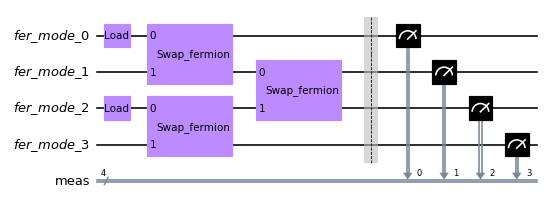

In [9]:
circ = backend.initialize_circuit([1, 0, 1, 0])

circ.append(swap_fermions, qargs=[0, 1])
circ.append(swap_fermions, qargs=[2, 3])
circ.append(swap_fermions, qargs=[1, 2])

circ.measure_all()
circ.draw(output='mpl', scale=0.8)

In [10]:
job = backend.run(circ)

print(job.result().get_counts())

{'0011': 1000}


The fermions initialized at positions 0 and 2 got moved to position 2 and 3. Therefore, the outcome '0011' is always measured at each shot.

### Superposition

With the SWAP gate only, the system will always stay in a computational basis state. To create a superposition we define a similar gate which lets a particle tunnel from mode $i$ to mode $j$. This is achieved by applying the same Hamiltonian $H_{\text{swap}}$ for half the time, i.e. with a prefactor half as large.  

In [11]:
# define a gate which will create superposition in the circuit
split_fermions = FermionicGate(name="split_fermion", num_modes=2, generator=H_swap/2)

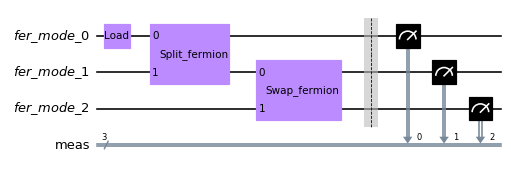

In [12]:
qc_sup = backend.initialize_circuit([1, 0, 0])

qc_sup.append(split_fermions, qargs=[0, 1])
qc_sup.append(swap_fermions, qargs=[1, 2])

qc_sup.measure_all()
qc_sup.draw(output='mpl', scale=0.8)

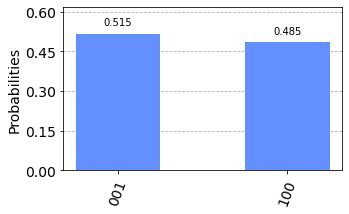

In [13]:
from qiskit.visualization import plot_histogram

job_sup = backend.run(qc_sup)

plot_histogram(job_sup.result().get_counts(), figsize=(5, 3))

We now see that the single particle in the register is found either in mode 0 or mode 2 with equal probability.

## The fermionic simulator backend

We have already seen above how to use the `FermionSimulator` to simulate measurements of the occupation of the fermionic modes. Internally, this backend simulates the evolution of the circuit by exact diagonalization and therefore also has access to the statevector and unitary of the system in the familiar way of `result.get_statevector()` and `result.get_unitary()`. If there is a final measurement in the circuit, the returned state and unitary of the circuit are those just prior to measurement.

counts : {'1010': 1, '0011': 1, '1100': 5, '0101': 3}

memory : ['0011', '1010', '0101', '1100', '1100', '0101', '0101', '1100', '1100', '1100']

statevector : [0.-0.5j 0.+0.5j 0.+0.j  0.+0.j  0.+0.5j 0.-0.5j]

circuit unitary : 
 [[ 0. +0.j   0.5+0.j   0. +0.5j  0. -0.5j  0.5+0.j   0. +0.j ]
 [ 0. +0.j   0.5+0.j   0. +0.5j  0. +0.5j -0.5+0.j   0. +0.j ]
 [ 0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +1.j ]
 [ 0. -1.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j ]
 [ 0. +0.j  -0.5+0.j   0. +0.5j  0. +0.5j  0.5+0.j   0. +0.j ]
 [ 0. +0.j  -0.5+0.j   0. +0.5j  0. -0.5j -0.5+0.j   0. +0.j ]]


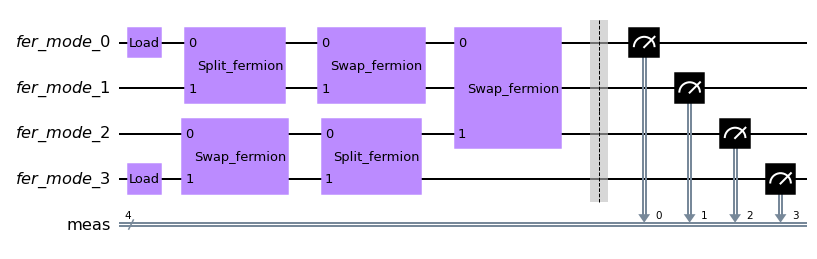

In [14]:
qc = backend.initialize_circuit([1, 0, 0, 1])

qc.append(split_fermions, qargs=[0, 1])
qc.append(swap_fermions, qargs=[2, 3])
qc.append(swap_fermions, qargs=[0, 1])
qc.append(split_fermions, qargs=[2, 3])
qc.append(swap_fermions, qargs=[0, 2])

qc.measure_all()

job = backend.run(qc, shots = 10, seed=1234)

# access the counts
print("counts :", job.result().get_counts())

# access the memory of individual outcomes
print("\nmemory :", job.result().get_memory())

# access the statevector 
print("\nstatevector :", job.result().get_statevector())

# accedd the unitary
print("\ncircuit unitary : \n", job.result().get_unitary())

qc.draw(output='mpl')

Note that the statevector and unitary are defined in a Hilbert space of dimension six. This is because the simulator checks for the conservation of the total number of particles under the applied gates. If all gates conserve the total particle number, the simulation will only be carried out in the relevant subspace. In order to see which index in this basis belongs to which state, the basis of the simulation of a circuits can be accessed as:

In [15]:
print(backend.get_basis(qc))


 0.   |0, 0, 1, 1>
 1.   |0, 1, 0, 1>
 2.   |0, 1, 1, 0>
 3.   |1, 0, 0, 1>
 4.   |1, 0, 1, 0>
 5.   |1, 1, 0, 0>


### Measuring observables

The fermionic backends come with a method to sample the expectation value of observables which are diagonal in the occupation number basis. 
Like the gate Hamiltonians, these observables are given as a `FermionicOp`.

For example, we can measure the correlation of the occupations of two sites in the above circuit:

In [16]:
corr = FermionicOp("NINI") + FermionicOp("EIEI")

exp_val = backend.measure_observable_expectation(qc, observable=corr, shots=1000)

print(exp_val)

[0.484]


### Further remarks

The `FermionSimulator` is a general simulator backend in the sense that it accepts any `FermionicGate` with a well-defined fermionic generator. Similar to the `qasm_simulator` for qubits, there are no coupling maps or further restrictions posed on the applicable gates. 

To see how fermionic circuits can describe a concrete experimental system of ultracold fermionic atoms with the gateset and coupling map of a real device please see the [fermionic tweezer hardware tutorial](./03_fermionic_tweezer_hardware.ipynb).

## References
[1] Gross, Christian and Bloch, Immanuel *Quantum simulations with ultracold atoms in optical lattices*, Science, 357, 995-1001, 2017

In [18]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright